# Calculate ILAMB Data
Creates annual, regridded data as well as month of max and climatology, from raw ILAMB data. Uses a config file (e.g. ILAMB_obs.cfg) to get information about where ILAMB data is located and what the files, models, and variable names are.

In [1]:
import os
import warnings
import xarray as xr

import fates_calibration_library.utils as utils
import fates_calibration_library.ilamb_functions as ilamb
import fates_calibration_library.analysis_functions as analysis

# ignore warnings about latitude being outside of -90, 90
warnings.simplefilter("ignore", UserWarning)

In [2]:
# config file for ILAMB data
ilamb_cfg = '/glade/work/afoster/FATES_calibration/fates_calibration_library/configs/ILAMB_obs.yaml'

# land area file
land_area_ds = os.path.join("/glade/derecho/scratch/afoster/archive",
                            "ctsm60SP_bigleaf_fullgrid/lnd/hist",
                            "ctsm60SP_bigleaf_fullgrid.clm2.h0.0001-02-01-00000.nc")

In [3]:
# config dictionary for running functions
config_dict = {
    'top_dir': '/glade/campaign/cesm/community/lmwg/diag/ILAMB/DATA',  # location of raw ILAMB data
    'regrid_dir': '/glade/work/afoster/FATES_calibration/observations/ILAMB_obs/regridded',  # where to put regridded ILAMB data
    'regrid_tag': '2deg',
    'out_dir': '/glade/work/afoster/FATES_calibration/observations/ILAMB_obs',  # where to put compiled ILAMB data
    'start_date': None,  # start date to filter to
    'end_date': None,  # end date to filter to
    'user': 'afoster@ucar.edu',  # user
    'clobber': False,  # overwrite files?
}

In [4]:
# read in the ILAMB data dictionary
ilamb_dict = utils.get_config_file(ilamb_cfg)

In [5]:
# create a target grid to regrid to
target_grid = analysis.create_target_grid(land_area_ds, 'FSR')

In [67]:
import importlib
import fates_calibration_library.ilamb_functions
import fates_calibration_library.analysis_functions
importlib.reload(fates_calibration_library.ilamb_functions)
importlib.reload(fates_calibration_library.analysis_functions)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xesmf as xe
import matplotlib

In [86]:
def quick_map(da, cmap):


    cmap = matplotlib.colormaps.get_cmap(cmap).copy()
    cmap.set_bad(color='#DFDFDF', alpha=0)
    
    figure, ax = plt.subplots(
        1,
        1,
        figsize=(13, 6),
        subplot_kw=dict(projection=ccrs.Robinson()),
        layout="compressed",
    )
    ax.coastlines()
    ax.add_feature(
        cfeature.NaturalEarthFeature("physical", "ocean", "110m", facecolor="#BFBFBF")
    )
    # Do the plotting
    pcm = ax.pcolormesh(
        da.lon,
        da.lat,
        da,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
    )
    cbar = figure.colorbar(pcm, ax=ax, shrink=0.5, orientation="horizontal")

In [57]:
# loop through dictionary and regrid the ILAMB observations
# script will skip files that already exist unless clobber: True
# ilamb.regrid_all_ilamb_data(config_dict, ilamb_dict, target_grid)

In [7]:
region = xr.open_dataset(os.path.join(config_dict['top_dir'],
                                      'regions/GlobalLandNoAnt.nc'))

# swap out 0.0 (land) for 1.0
region['ids'] = xr.where(region.ids == 0.0, 1.0, 0.0)

In [8]:
dataset = 'FLUXCOM_GPP'
attributes = ilamb_dict[dataset]
res = '2deg'

file_name = os.path.join(
    config_dict["regrid_dir"],
    f"{attributes['model']}_{attributes['out_var'].upper()}_{res}.nc",
)
regridded_dat = xr.open_dataset(file_name)

In [89]:
metadata = {
    "units": attributes["units"],
    "longname": attributes["longname"],
    "original_file": file_name,
    "user": config_dict["user"],
}

annual_ds = ilamb.get_annual_ds(
    regridded_dat,
    attributes["in_var"],
    attributes["out_var"],
    ilamb.evaluate_conversion_factor(attributes["time_conversion_factor"]),
    metadata,
)
sum_annual = annual_ds[attributes["out_var"]].sum(dim='year')
annual_ds = annual_ds.where(np.abs(sum_annual) > 0.0)

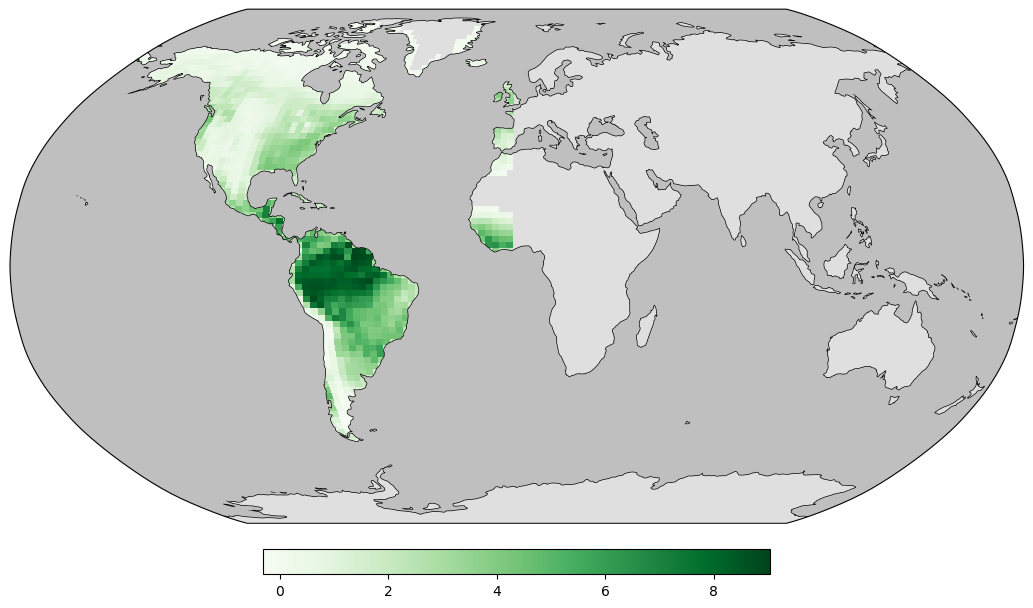

In [85]:
quick_map(annual_ds.mean(dim='year')[attributes['out_var']], 'Greens')

In [74]:
ilamb_dat, original_file = ilamb.read_ilamb_data(config_dict, ilamb_dict, attributes)


area_da = ilamb.get_ilamb_land_area(ilamb_dat)
ilamb_dat['cell_area'] = area_da

# regrid regions
region_regridder = xe.Regridder(region['ids'], ilamb_dat, 'bilinear')
region_regrid = region_regridder(region['ids'])
ilamb_dat['landfrac'] = region_regrid
ilamb_dat['land_area'] = ilamb_dat.landfrac*ilamb_dat.cell_area

In [87]:
annual_original = ilamb.get_annual_ds(
    ilamb_dat,
    attributes["in_var"],
    attributes["out_var"],
    ilamb.evaluate_conversion_factor(attributes["time_conversion_factor"]),
    metadata,
)
sum_annual = annual_original[attributes["out_var"]].sum(dim='year')
annual_original = annual_original.where(np.abs(sum_annual) > 0.0)

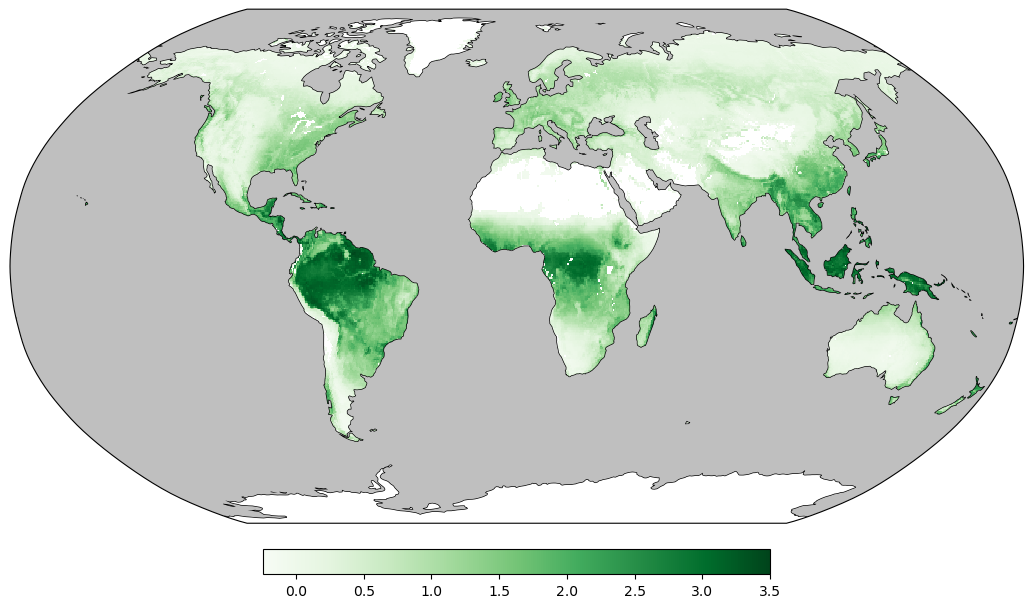

In [88]:
quick_map(annual_original.mean(dim='year')[attributes['out_var']], 'Greens')

In [90]:
global_mean = analysis.area_mean(annual_original[attributes["out_var"]].mean(dim='year'), 
                        ilamb.evaluate_conversion_factor(attributes["area_conversion_factor"]), 
                        ilamb_dat['land_area']).to_dataset(name=f"{attributes['out_var']}_global")

In [91]:
global_mean

<xarray.Dataset>
Dimensions:     ()
Data variables:
    gpp_global  float64 113.4

In [ ]:
monthly_mean = ilamb.get_monthly_ds(
    ilamb_dat[attributes["in_var"]],
    f"{attributes['out_var']}_monthly",
    ilamb.evaluate_conversion_factor(attributes["time_conversion_factor"]),
    metadata
)

In [ ]:
monthly_mean['land_area'] = ilamb_dat.landfrac*ilamb_dat.cell_area

In [ ]:
regridded_monthly_mean = ilamb.get_monthly_ds(
    regridded_dat[attributes["in_var"]],
    f"{attributes['out_var']}_monthly",
    ilamb.evaluate_conversion_factor(attributes["time_conversion_factor"]),
    metadata
)
month_of_max = ilamb.calculate_month_of_max(
    regridded_monthly_mean[f"{attributes['out_var']}_monthly"]
).to_dataset(name=f"{attributes['out_var']}_month_of_max")

In [ ]:
climatology_ds = ilamb.get_ilamb_climatology(
    monthly_mean,
    attributes["out_var"],
    ilamb.evaluate_conversion_factor(attributes["area_conversion_factor"]),
)

In [ ]:
climatology_ds.albedo_cycle.plot()

In [ ]:
# loop through dictionary and process the regridded ILAMB observations
# script will skip files that already exist unless clobber: True
ilamb.get_all_ilamb_data(config_dict, ilamb_dict, '2deg')

In [ ]:
# compile data into one dataset
compiled_ds = ilamb.compile_ilamb_datasets(config_dict['out_dir'], ilamb_dict,
                                           target_grid.area)
compiled_ds.to_netcdf(os.path.join('/glade/work/afoster/FATES_calibration',
                                   'observations/all_ILAMB_obs.nc'), mode="w")

In [ ]:
plot_config_file = '/glade/work/afoster/FATES_calibration/fates_calibration_library/configs/ilamb_conversion.yaml'
plot_config = utils.get_config_file(plot_config_file)

In [ ]:
plotvar = 'EF'
model = 'FLUXCOM'
global_var = ilamb.get_model_da(compiled_ds, 
                               f"{plot_config[plotvar]['var']}_global",
                               plot_config[plotvar]['models'])


clim_var = ilamb.get_model_da(compiled_ds, 
                               f"{plot_config[plotvar]['var']}_cycle",
                               plot_config[plotvar]['models'])

annual_var = ilamb.get_model_da(compiled_ds, 
                               f"{plot_config[plotvar]['var']}",
                               plot_config[plotvar]['models'])

In [ ]:
global_var.model.values

In [ ]:
global_var.sel(model=model).values

In [ ]:
clim_var.sel(model=model).plot();

In [ ]:
annual_var.sel(model=model).plot(cmap='jet')